In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from h5py import File
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
from vis_utils import plot_time_series
import numpy as np

In [6]:
# define the transform function
trans = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str,
                 response_type: str,
                 transform: transforms.Compose = trans,
                 train: bool= True):
        self.file_path = path
        # The available types are firing_rate_10ms, binned
        self.response_type = response_type
        self.X = None
        self.y = None
        self.transform = transform
        # Choose either train or test subsets
        self.data_type = "train" if train else "test"
        with File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.data_type]["stimulus"])

    def __getitem__(self, idx: int):
        if self.X is None or self.y is None:
            h5file = File(self.file_path, 'r')
            # Read as numpy array
            # TODO: see if there is a better way
            self.X = np.asarray(h5file[self.data_type]["stimulus"])
            self.y = np.asarray(h5file[self.data_type]["response"][self.response_type])
            # Swap axes of y since it is channels last
            self.y = np.transpose(self.y, axes=None)
            self.y = self.y.astype("float32")

        # transform the data
        x = self.transform(self.X[idx])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

    def __len__(self):
        return self.dataset_len

In [8]:
# adjust a path to the sample h5 file
dataset_path = "../data/neural_code_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5"

train_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
test_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=False)

In [9]:
# split train dataset into train and validation
# shuffle and split the dataset
torch.manual_seed(12)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print("Number of training images", len(train_dataset))
print("Number of validation images", len(val_dataset))
print("Number of testing images", len(test_dataset))

Number of training images 287841
Number of validation images 71961
Number of testing images 5996


In [10]:
# create data loaders
BATCH_SIZE = 2500
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model definition #

Very simple CNN model at the beginning. In the first trial approach we will train the model that tries to predict original response values in the range [0, inf).


In [3]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels= 2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels= 4 * out_channels, kernel_size=3, stride=1, padding=1)
        # Fully connected layer
        self.fc = nn.Linear(50 * 50 * 4 * out_channels, self.n_units)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch
        # Forward pass through the fully connected layer to predict ganglion cell responses
        x = self.fc(x)
        return x

model = RetinaCNN()

In [8]:
# define training parameters
LEARNING_RATE = 0.005
EPOCHS = 70
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()


In [9]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()

for epoch in range(EPOCHS):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader, desc='Training Batches', leave=False):
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in val_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), '../models/best_model_simple_3conv.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')

    torch.save(model.state_dict(), '../models/final_model_simple_3conv.pth')

Training Batches:   0%|          | 0/116 [00:00<?, ?it/s]/root/miniconda3/envs/neural_deep/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 		 Training Loss: 106.74756931436472 		 Validation Loss: 101.01058828419653


Epoch 2 		 Training Loss: 101.5340805053711 		 Validation Loss: 100.38649170974205


Epoch 3 		 Training Loss: 100.98224600430193 		 Validation Loss: 100.07575252138335


Epoch 4 		 Training Loss: 100.54814891157478 		 Validation Loss: 99.81591744258486


Epoch 5 		 Training Loss: 99.76987075805664 		 Validation Loss: 99.40434501911032


Epoch 6 		 Training Loss: 99.00429975575415 		 Validation Loss: 98.89933566389412


Epoch 7 		 Training Loss: 98.53891379257729 		 Validation Loss: 98.56907943199421


Epoch 8 		 Training Loss: 97.39714313375539 		 Validation Loss: 98.15913022797683


Epoch 9 		 Training Loss: 96.79041467863938 		 Validation Loss: 97.91401777596309


Epoch 10 		 Training Loss: 95.74822721810176 		 Validation Loss: 97.35155145053206


Epoch 11 		 Training Loss: 94.760144069277 		 Validation Loss: 97.02334989350418


Epoch 12 		 Training Loss: 94.03810487944504 		 Validation Loss: 96.48374833731816


Epoch 13 		 Training Loss: 93.28027310864678 		 Validation Loss: 96.2199286099138


Epoch 14 		 Training Loss: 92.85562620491817 		 Validation Loss: 95.98479593211206


Epoch 15 		 Training Loss: 92.26691292072165 		 Validation Loss: 95.62842954438308


Epoch 16 		 Training Loss: 91.86812479742642 		 Validation Loss: 95.55262309107287


Epoch 17 		 Training Loss: 91.23123359680176 		 Validation Loss: 95.18829687710466


Epoch 18 		 Training Loss: 90.83216568519329 		 Validation Loss: 95.14797447467673


Epoch 19 		 Training Loss: 90.5775757493644 		 Validation Loss: 95.45686314023774


Epoch 20 		 Training Loss: 90.20583810477422 		 Validation Loss: 95.08266343741582


Epoch 21 		 Training Loss: 89.98179304188696 		 Validation Loss: 95.04482190362339


Epoch 22 		 Training Loss: 89.59304599104256 		 Validation Loss: 94.82056032378098


Epoch 23 		 Training Loss: 89.41958572124612 		 Validation Loss: 94.64117668414939


Epoch 24 		 Training Loss: 89.05553666476546 		 Validation Loss: 94.51010131835938


Epoch 25 		 Training Loss: 89.11812769133469 		 Validation Loss: 94.73374912656587


Epoch 26 		 Training Loss: 88.61437804123452 		 Validation Loss: 94.49311091982085


Epoch 27 		 Training Loss: 88.49550174844676 		 Validation Loss: 94.3625101549872


Epoch 28 		 Training Loss: 88.48038245891702 		 Validation Loss: 94.28286611622778


Epoch 29 		 Training Loss: 88.20520861395474 		 Validation Loss: 94.08018020103718


Epoch 30 		 Training Loss: 88.28566084236934 		 Validation Loss: 93.93655000883957


Epoch 31 		 Training Loss: 87.98173187518942 		 Validation Loss: 93.89724100047144


Epoch 32 		 Training Loss: 87.83972858560496 		 Validation Loss: 94.03793150803139


Epoch 33 		 Training Loss: 87.85315066370471 		 Validation Loss: 93.93915952485183


Epoch 34 		 Training Loss: 87.69830591925259 		 Validation Loss: 93.76509225779566


Epoch 35 		 Training Loss: 87.57850495700178 		 Validation Loss: 93.75831340921336


Epoch 36 		 Training Loss: 87.43612236812197 		 Validation Loss: 93.67260663262729


Epoch 37 		 Training Loss: 87.21890988843194 		 Validation Loss: 93.83536319074959


Epoch 38 		 Training Loss: 87.00100056878452 		 Validation Loss: 93.37028950658338


Epoch 39 		 Training Loss: 86.48386271246548 		 Validation Loss: 93.16409249141299


Epoch 40 		 Training Loss: 86.20726572234055 		 Validation Loss: 93.26395837191878


Epoch 41 		 Training Loss: 86.09016793349693 		 Validation Loss: 93.15410666630186


Epoch 42 		 Training Loss: 85.80494321625808 		 Validation Loss: 92.79066756675984


Epoch 43 		 Training Loss: 85.49709346376616 		 Validation Loss: 92.73532209725215


Epoch 44 		 Training Loss: 85.16574221643909 		 Validation Loss: 92.54424575279499


Epoch 45 		 Training Loss: 84.95872333131987 		 Validation Loss: 93.15766591039197


Epoch 46 		 Training Loss: 84.51114411189639 		 Validation Loss: 91.97869978279903


Epoch 47 		 Training Loss: 84.22336538906755 		 Validation Loss: 91.87549591064453


Epoch 48 		 Training Loss: 83.96461335543928 		 Validation Loss: 91.65000731369545


Epoch 49 		 Training Loss: 83.6815348000362 		 Validation Loss: 91.72227293869545


Epoch 50 		 Training Loss: 83.72975987401502 		 Validation Loss: 91.59155694369612


Epoch 51 		 Training Loss: 83.36618449770171 		 Validation Loss: 91.5064442075532


Epoch 52 		 Training Loss: 83.03986707226983 		 Validation Loss: 91.27678496262124


Epoch 53 		 Training Loss: 82.8653719014135 		 Validation Loss: 91.34829448831492


Epoch 54 		 Training Loss: 82.71344296685581 		 Validation Loss: 91.18371739880791


Epoch 55 		 Training Loss: 82.38841083131987 		 Validation Loss: 91.09390100939521


Epoch 56 		 Training Loss: 82.28425012785813 		 Validation Loss: 90.86406392064588


Epoch 57 		 Training Loss: 81.84798434685017 		 Validation Loss: 90.80511132602034


Epoch 58 		 Training Loss: 81.81376312518942 		 Validation Loss: 90.88385562239021


Epoch 59 		 Training Loss: 81.56766444239123 		 Validation Loss: 90.1770151072535


Epoch 60 		 Training Loss: 81.2168759313123 		 Validation Loss: 90.57564912993332


Epoch 61 		 Training Loss: 81.25543410202553 		 Validation Loss: 91.36635352825296


Epoch 62 		 Training Loss: 81.03068535903404 		 Validation Loss: 90.16479992044383


Epoch 63 		 Training Loss: 80.75329070255674 		 Validation Loss: 89.92288997255523


Epoch 64 		 Training Loss: 80.5714734833816 		 Validation Loss: 89.59048803921404


Epoch 65 		 Training Loss: 80.355741961249 		 Validation Loss: 90.03057756095097


Epoch 66 		 Training Loss: 80.0523260708513 		 Validation Loss: 89.52404943005791


Epoch 67 		 Training Loss: 79.89648305958715 		 Validation Loss: 89.55143395785628


Epoch 68 		 Training Loss: 79.76498952405206 		 Validation Loss: 89.78269800646552


Epoch 69 		 Training Loss: 79.57712160307786 		 Validation Loss: 89.3452561477135


Epoch 70 		 Training Loss: 79.45361564899314 		 Validation Loss: 89.16715766643655


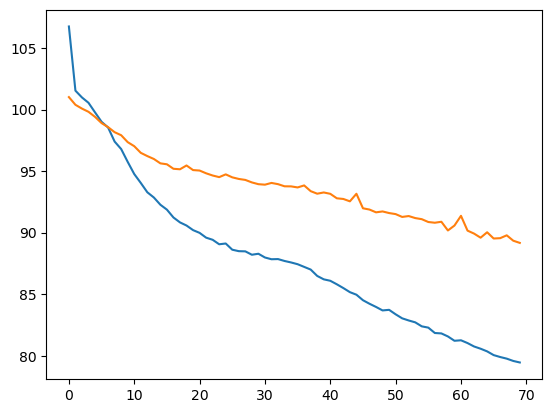

In [16]:
# plot the training and validation losses
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['valid_losses'], label='Validation Loss')

# Inference test set

Plot the actual and predicted values and calculate the correlation

In [2]:
# function for a test loader predictions
def predict_loader(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc='Batches'):
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)


In [4]:
# load the best model
model = RetinaCNN()
model.load_state_dict(torch.load('../models/best_model_simple_3conv.pth'))
model.cuda()

RetinaCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=80000, out_features=9, bias=True)
)

In [11]:
predictions, targets = predict_loader(model, test_loader)

Batches: 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]


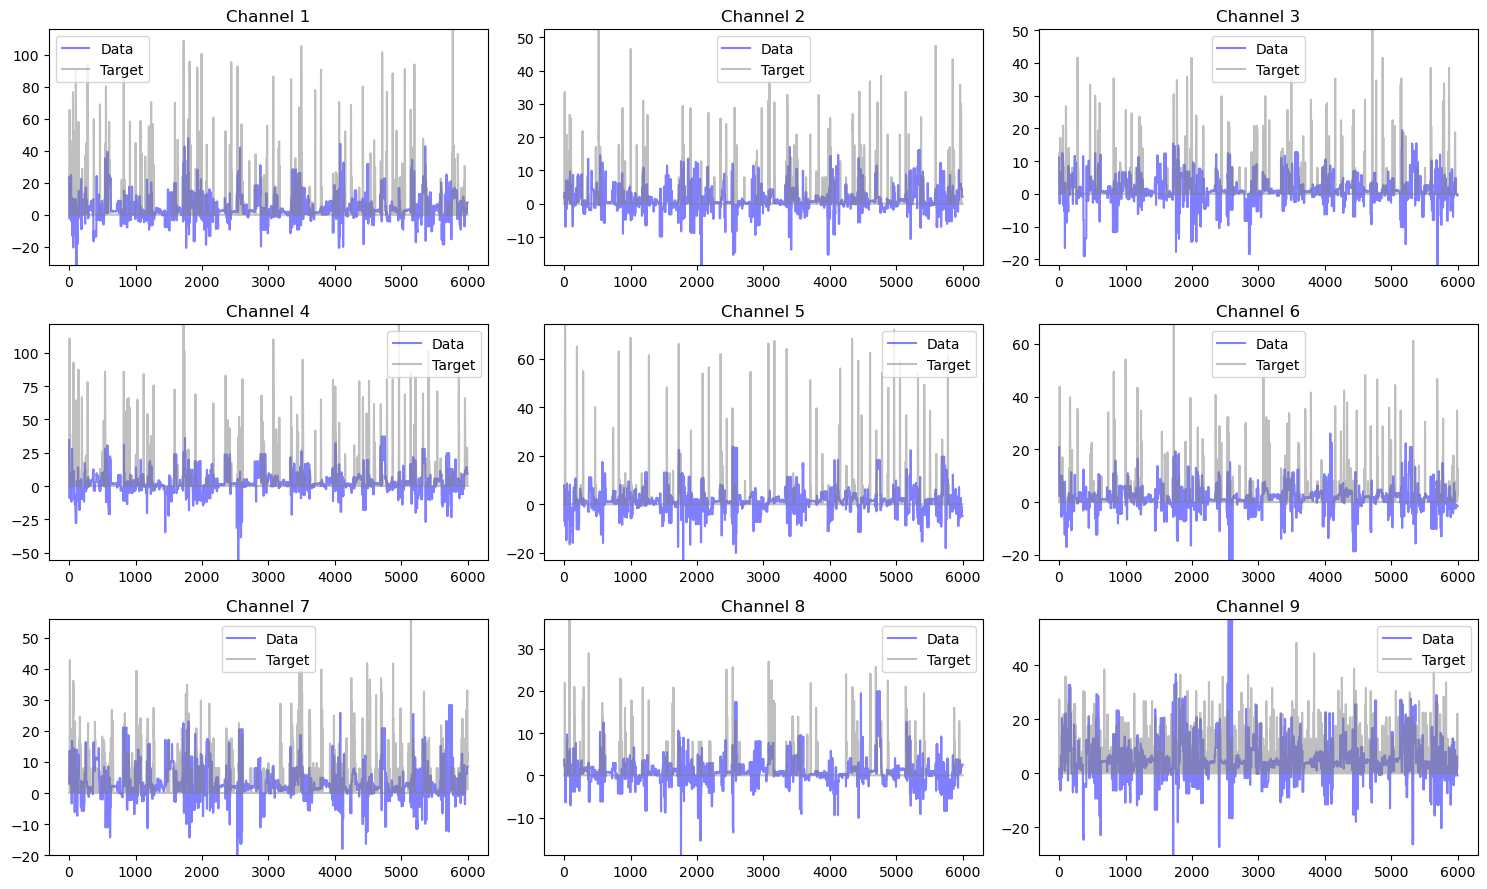

In [12]:
plot_time_series(np.transpose(predictions), np.transpose(targets))

In [32]:
max(np.transpose(predictions)[0])

3.4512012004852295